In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt



In [11]:
# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define the function to extract the features from an image
def extract_features(image_path, model):
    # Open the image and apply the preprocessing steps
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    # Extract the features using the model
    with torch.no_grad():
        features = model(image_tensor).squeeze()
    # Normalize the features to unit length
    features /= features.norm()
    # Convert the features to a numpy array
    features = features.numpy()
    return features

In [12]:
import os 
import random 
import shutil

# Set the path to the data folder
data_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\archive\167"

# Set the path to the training and validation folders
train_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\train"
val_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\val"

# Set the split ratio between training and validation sets
split_ratio = 0.8

# Create the training and validation folders if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Get the list of all image files in the data folder
image_files = [f for f in os.listdir(data_path) if f.endswith(".jpg")]

# Shuffle the image files randomly
random.shuffle(image_files)

# Split the image files into training and validation sets
split_index = int(len(image_files) * split_ratio)
train_image_files = image_files[:split_index]
val_image_files = image_files[split_index:]

# Copy the training images to the training folder
for image_file in train_image_files:
    src_path = os.path.join(data_path, image_file)
    dst_path = os.path.join(train_path, image_file)
    shutil.copyfile(src_path, dst_path)

# Copy the validation images to the validation folder
for image_file in val_image_files:
    src_path = os.path.join(data_path, image_file)
    dst_path = os.path.join(val_path, image_file)
    shutil.copyfile(src_path, dst_path)


In [13]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        
        for filename in os.listdir(self.data_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                self.images.append(os.path.join(self.data_dir, filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, 0  # All images belong to a single class, so we can assign a fixed label value to all of them


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os

train_data_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\train"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
train_dataset = CustomDataset(train_data_path, train_transforms)


# Set num_samples to the number of samples in train_dataset
num_samples = len(train_dataset)


# Define the validation dataset
val_data_path = r"C:\Users\marad\OneDrive\Desktop\DB_project\val"

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_dataset = CustomDataset(val_data_path, val_transforms)

# Set num_samples to the number of samples in train_dataset
num_samples = len(val_dataset)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers = 0)

# Load the ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model on the training dataset
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)
    
    # Calculate the accuracy of the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    
    # Evaluate the model on the validation dataset
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    # Print the epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Validation Accuracy: 100.00%
Epoch 1/10, Train Loss: 0.6493, Val Loss: 0.3282, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.1352, Val Loss: 0.0924, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0312, Val Loss: 0.0290, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0114, Val Loss: 0.0121, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0059, Val Loss: 0.0065, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0040, Val Loss: 0.0043, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0030, Val Loss: 0.0031, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0025, Val Loss: 0.0025, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 9/10, Train Loss: 0.0021, Val Loss: 0.0021, Val Acc: 1.0000
Validation Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0019, Val Loss: 0.0019, Val Acc: 1.0000


In [6]:
# Define the function to retrieve the most similar images to a query image
def retrieve_similar_images(query_image_path, database_df, model, top_k=10):
    # Extract the features of the query image
    query_features = extract_features(query_image_path, model)

    # Compute the distances between the query image and all the images in the database
    distances = np.linalg.norm(database_df['embedding'].tolist() - query_features, axis=1)

    # Retrieve the indices of the top-k most similar images
    top_k_indices = np.argsort(distances)[:top_k]

    # Get the image paths and distances of the top-k most similar images
    top_k_image_paths = database_df.loc[top_k_indices, 'image_path'].tolist()
    top_k_distances = distances[top_k_indices]

    # Return the top-k most similar images along with their image paths and distances
    return list(zip(top_k_image_paths, top_k_distances))

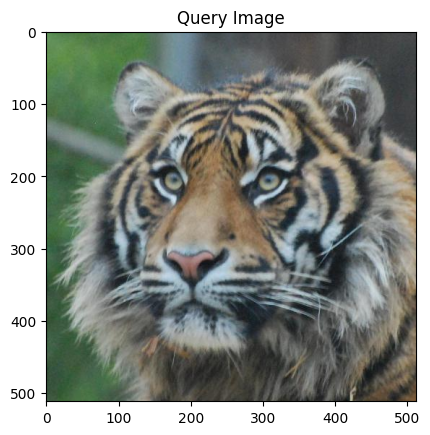

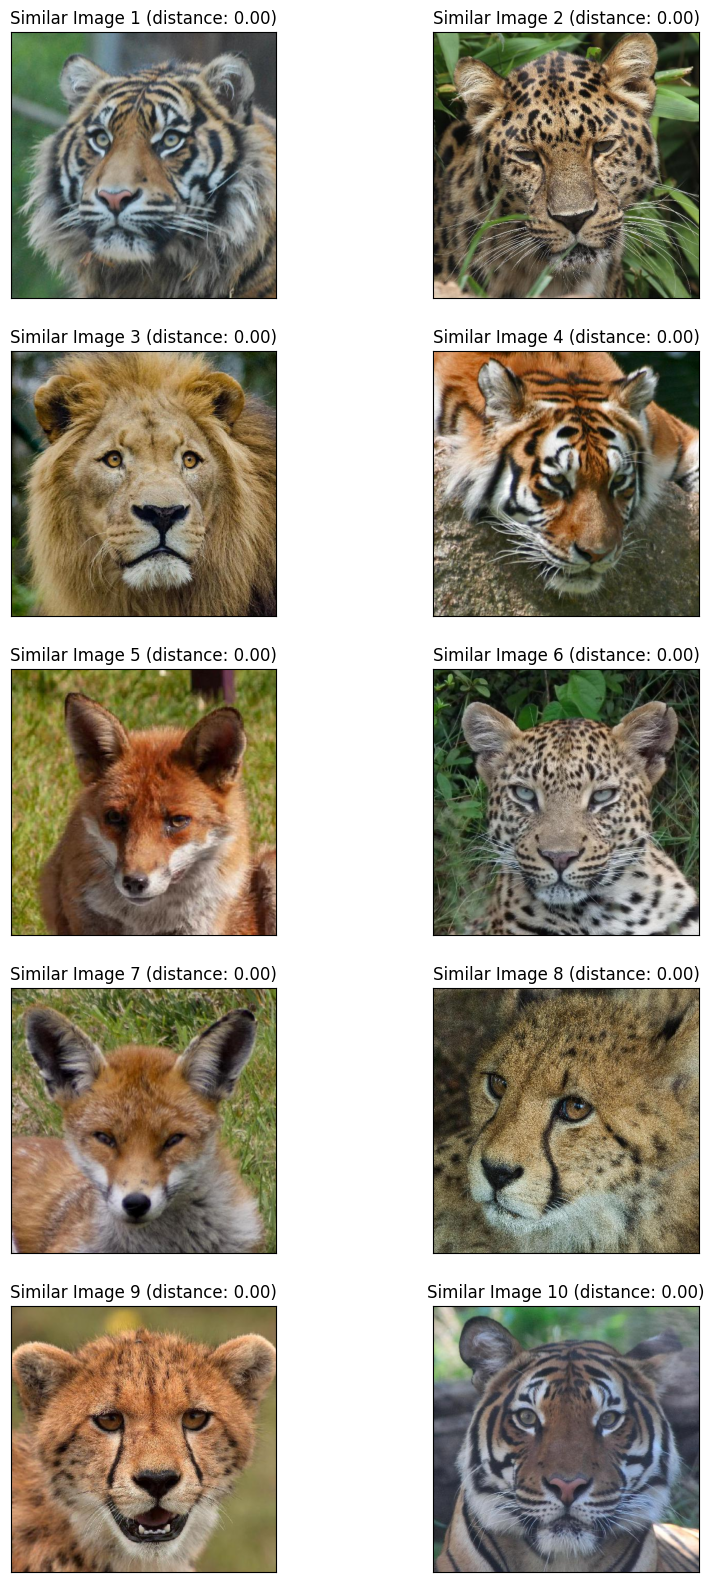

In [9]:
# Load the image database and preprocess all the images
database_path = Path("C:/Users/marad/OneDrive/Desktop/DB_project/archive/167/")

image_paths = list(database_path.glob("*.jpg"))
image_embeddings = [extract_features(str(image_path), model) for image_path in image_paths]
df = pd.DataFrame({'image_path': image_paths, 'embedding': image_embeddings})

# Retrieve similar images for a query image
query_image_path = "C:/Users/marad/OneDrive/Desktop/DB_project/archive/167/15.jpg"
similar_images = retrieve_similar_images(query_image_path, df, model, top_k=10)

# # Print the top-k most similar images along with their distances
# for i, (image_path, distance) in enumerate(similar_images):
#     print(f"Image {i+1}: {image_path} (distance: {distance:.2f})")
    
    
import matplotlib.pyplot as plt

# Display the query image
query_image = Image.open(query_image_path)
plt.imshow(query_image)
plt.title('Query Image')
plt.show()

# # Display the similar images
# for i, (image_path, distance) in enumerate(similar_images):
#     similar_image = Image.open(image_path)
#     plt.imshow(similar_image)
#     plt.title(f'Similar Image {i+1} (distance: {distance:.2f})')
#     plt.show()


# Display the similar images
similar_images = retrieve_similar_images(query_image_path, df, model, top_k=10)

num_rows = 5
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 20))
for i, (image_path, distance) in enumerate(similar_images):
    row = i // num_cols
    col = i % num_cols
    similar_image = Image.open(image_path)
    axes[row, col].imshow(similar_image)
    axes[row, col].set_title(f'Similar Image {i+1} (distance: {distance:.2f})')

# Hide the x and y axis labels for all subplots
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
